**I tried binary classification solution using LightGBM like CTR prediction**  
**Please upvote if this notebook is useful!**

In [56]:
import os
import sys

In [60]:
import pandas as pd
import numpy as np
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import joblib
import re


In [3]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
print(f"System Version: {sys.version}")
print(f"lightgbm Version: {lightgbm.__version__}")


System Version: 3.8.16 (default, Mar  1 2023, 21:19:10) 
[Clang 14.0.6 ]
lightgbm Version: 3.3.5


In [4]:
class Config:
    transaction_path = "h-and-m-personalized-fashion-recommendations/transactions_train.csv"
    transaction_2020_path = "h-and-m-split-dataset-by-year/transactions_train_2020.csv"
    transaction_2019_path = "h-and-m-split-dataset-by-year/transactions_train_2019.csv"
    customer_path = "h-and-m-personalized-fashion-recommendations/customers.csv"
    article_path = "h-and-m-personalized-fashion-recommendations/articles.csv"
    image_feat_path = "h-and-m-swint-image-embedding/swin_tiny_patch4_window7_224_emb.csv.gz"
    sample_submission_path = "h-and-m-personalized-fashion-recommendations/sample_submission.csv"

    output_dir = "output/"
    #start_date = '2020-08-01'
    start_date = '2020-09-15'

    image_feat_dim = 768
    text_feat_dim = 384
    
    #n_fold = 2
    n_fold = 5
    seed = 2022
    lgbm = {"n_estimators" :50}

    label = "label"

os.makedirs(Config.output_dir, exist_ok=True)

In [5]:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# preprae truth/false

Given transaction data, that are user-item pairs, are defined as positive data.  
Negative data are created by shuffing user-item pairs.

In [6]:
df_trans = pd.read_csv(Config.transaction_2020_path)
df_trans = df_trans[df_trans["t_dat"] >= Config.start_date].reset_index(drop=True)
df_trans = reduce_mem_usage(df_trans)

Memory usage of dataframe is 10.16 MB
Memory usage after optimization is: 5.64 MB
Decreased by 44.5%


In [7]:
df_truth = df_trans[["customer_id", "article_id"]]
df_truth.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007
1,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,875272011
2,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,875272012
3,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,800691007
4,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,800691007


In [8]:
del df_trans

In [9]:
df_false = df_truth.copy()
df_false.loc[:, "article_id"] = df_false["article_id"].sample(frac=1).tolist()
df_false.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,915526002
1,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,785855001
2,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,697564057
3,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,751471001
4,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,790365001


In [10]:
df_truth.loc[:, Config.label] = 1
df_false.loc[:, Config.label] = 0

In [11]:
df_truth = pd.concat([df_truth, df_false])
df_truth.shape, 

((532728, 3),)

In [12]:
df_truth[df_truth["label"] ==1].shape,  df_truth[df_truth["label"] ==0].shape, 

((266364, 3), (266364, 3))

In [13]:
del df_false

# Preprocessing
## prepare article feat

In [14]:
df_article = import_data(Config.article_path)
#df_image = import_data(Config.image_feat_path)
#df_text = import_data(Config.text_feat_path)

Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%


In [15]:
def get_table_feat(df):
        
    article_id_cols = ["product_code", "product_type_no", "graphical_appearance_no", "colour_group_code",
              "perceived_colour_value_id", "perceived_colour_master_id", "department_no", "index_group_no", 
               "section_no", "garment_group_no"]
    
    article_dummy_cols = ["product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name",
                         "perceived_colour_value_name", "perceived_colour_master_name", 
                         #"department_name", 
                         "index_name", "index_group_name", "section_name", "garment_group_name"]
    
    article_drop_cols = ["index_code", "prod_name", "detail_desc", "department_name"]
    
    df = df.drop(article_drop_cols, axis=1)
    df = pd.get_dummies(df, columns=article_dummy_cols)
    return df
    
def create_article_feat(df_article, 
                        #df_image
                        ):

    # rename image 
    #rename_dic = {f"{i}": f"image_col_{i}" for i in range(Config.image_feat_dim)}
    #df_image = df_image.rename(columns=rename_dic)

    df_article_feat = get_table_feat(df_article)
    #df_article_feat = df_article_feat.merge(df_image, on="article_id", how="left")

    return df_article_feat

In [16]:
#df_article_feat = create_article_feat(df_article, df_image, df_text)
df_article_feat = create_article_feat(df_article)

In [17]:
df_article_feat.head()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,...,garment_group_name_Shorts,garment_group_name_Skirts,garment_group_name_Socks and Tights,garment_group_name_Special Offers,garment_group_name_Swimwear,garment_group_name_Trousers,garment_group_name_Trousers Denim,"garment_group_name_Under-, Nightwear",garment_group_name_Unknown,garment_group_name_Woven/Jersey/Knitted mix Baby
0,108775015,108775,253,1010016,9,4,5,1676,1,16,...,0,0,0,0,0,0,0,0,0,0
1,108775044,108775,253,1010016,10,3,9,1676,1,16,...,0,0,0,0,0,0,0,0,0,0
2,108775051,108775,253,1010017,11,1,9,1676,1,16,...,0,0,0,0,0,0,0,0,0,0
3,110065001,110065,306,1010016,9,4,5,1339,1,61,...,0,0,0,0,0,0,0,1,0,0
4,110065002,110065,306,1010016,10,3,9,1339,1,61,...,0,0,0,0,0,0,0,1,0,0


In [18]:
#del df_article, df_image, df_text
del df_article

In [19]:
df_article_feat = reduce_mem_usage(df_article_feat)

Memory usage of dataframe is 37.54 MB
Memory usage after optimization is: 72.77 MB
Decreased by -93.8%


## prepare customer feat

In [20]:
df_customer = pd.read_csv(Config.customer_path)

create features

In [21]:
len(df_customer['postal_code'].unique())

352899

In [22]:
# 计算每个邮编的顾客数量
zipcode_counts = df_customer['postal_code'].value_counts()

# 将顾客数量分成两群
threshold = zipcode_counts.max()-1
group_labels = [0, 1]
groups = pd.cut(zipcode_counts, bins=[0, threshold, zipcode_counts.max()], labels=group_labels)

# 将邮编编码为 0 或 1
zipcode_encoding = dict(zip(zipcode_counts.index, groups.cat.codes))

# 将编码应用到原始数据中
df_customer['zipcode_encoding'] = df_customer['postal_code'].map(zipcode_encoding)

In [23]:
df_customer['zipcode_encoding'].value_counts()

0    1251677
1     120303
Name: zipcode_encoding, dtype: int64

In [ ]:
# 根據顧客過去7天消費的

In [24]:
def create_customer_feat(df):
    
    customer_drop_cols = ["postal_code"]
    customer_dummy_cols = ["club_member_status", "fashion_news_frequency"]
    
    
    df = df.drop(customer_drop_cols, axis=1)
    df.loc[:, "FN"] = df["FN"].fillna(0)
    df.loc[:, "Active"] = df["Active"].fillna(0)
    df.loc[:, "club_member_status"] = df["club_member_status"].fillna("NONE")
    df.loc[:, "fashion_news_frequency"] = df["fashion_news_frequency"].fillna("NONE")
    df.loc[:, "age"] = df["age"].fillna(0)
    df.loc[:, "age"] = np.log1p(df["age"])

    df = pd.get_dummies(df, columns=customer_dummy_cols)
    
    return df

In [25]:
df_customer_feat = create_customer_feat(df_customer)

In [26]:
del df_customer
df_customer_feat = reduce_mem_usage(df_customer_feat)

Memory usage of dataframe is 62.80 MB
Memory usage after optimization is: 78.04 MB
Decreased by -24.3%


In [27]:
df_customer_feat

,customer_id,FN,Active,age,zipcode_encoding,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,3.912109,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,3.257812,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,3.218750,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,4.007812,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,3.970703,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,3.218750,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,3.091797,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,3.091797,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,2.945312,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Merge all feats and construct dataset

In [28]:
gc.collect()

0

In [29]:
 # https://github.com/awslabs/autogluon/issues/399
df_article_feat = df_article_feat.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_customer_feat = df_customer_feat.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [30]:
# def create_dataset(df_truth, df_article_feat, df_customer_feat):

#     df_data = df_truth.merge(df_article_feat, on="article_id", how='left')
#     df_data = df_data.merge(df_customer_feat, on = "customer_id", how='left')    
#     df_data = df_data.drop(["customer_id", "article_id"], axis=1)    
#     df_data = df_data.fillna(0)

#     # https://github.com/awslabs/autogluon/issues/399
#     df_data = df_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#     return df_data

In [31]:
# https://www.kaggle.com/tkm2261/fast-pandas-left-join-357x-faster-than-pd-merge

df_article_feat = df_article_feat.set_index("article_id")
df_customer_feat = df_customer_feat.set_index("customer_id")

def create_dataset_faster(df_truth, df_article_feat, df_customer_feat): 

    df_data = pd.concat([
        df_truth.reset_index(drop=True), 
        df_article_feat.reindex(df_truth['article_id'].values).reset_index(drop=True)
    ], axis=1)
    df_data = pd.concat([
        df_data.reset_index(drop=True), 
        df_customer_feat.reindex(df_data['customer_id'].values).reset_index(drop=True)
    ], axis=1)  
    
    df_data = df_data.drop(["customer_id", "article_id"], axis=1)    
    df_data = df_data.fillna(0)


    return df_data

In [32]:
df_data = create_dataset_faster(df_truth, df_article_feat, df_customer_feat)

In [33]:
df_data.to_pickle(f"{Config.output_dir}/feature.pkl")

In [34]:
df_data.columns.shape

(373,)

In [35]:
df_data[df_data["label"] ==1].shape,  df_data[df_data["label"] ==0].shape, 

((266364, 373), (266364, 373))

In [54]:
df_data

,label,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,...,age,zipcode_encoding,club_member_status_ACTIVE,club_member_status_LEFTCLUB,club_member_status_NONE,club_member_status_PRECREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,1,794321,262,1010016,15,4,20,8397,26,5,...,3.218750,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,875272,259,1010023,7,2,12,1773,2,57,...,3.931641,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,875272,259,1010023,73,2,2,1773,2,57,...,3.931641,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,800691,255,1010016,10,3,9,1676,1,16,...,3.400391,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,800691,255,1010016,10,3,9,1676,1,16,...,3.400391,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532723,0,556539,512,1010016,9,4,5,4343,1,66,...,3.496094,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
532724,0,793025,259,1010016,17,4,13,1515,1,11,...,3.496094,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
532725,0,900422,272,1010016,9,4,5,1949,1,2,...,4.218750,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
532726,0,748566,273,1010001,13,2,11,8310,26,5,...,3.091797,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Training

In [36]:
def train(df_data):    
    cols = [col for col in df_data.columns if Config.label != col]

    folds = StratifiedKFold(n_splits=Config.n_fold, random_state=Config.seed, shuffle=True)
    es = early_stopping(1000)
    le = log_evaluation(period=100)
    scores = []    
        
    for fold, (train_idx, val_idx) in enumerate(folds.split(df_data, df_data[Config.label])):
        print(f"=====fold {fold}=======")

        df_train = df_data.loc[train_idx].reset_index(drop=True)
        df_val = df_data.loc[val_idx].reset_index(drop=True)
        
        print("train shape", df_train.shape, "test shape", df_val.shape)
        
        model = LGBMClassifier(random_state=Config.seed, **Config.lgbm)
        
        model.fit(df_train[cols], df_train[Config.label],
                eval_set=(df_val[cols], df_val[Config.label]),
                callbacks=[es, le],
                eval_metric="auc"              
                )
        
        # validation
        val_pred = model.predict(df_val[cols])
        val_score = roc_auc_score(df_val[Config.label], val_pred)
        scores.append(val_score)
        
        # save_model
        joblib.dump(model,f"lgbm_fold_{fold}.joblib")

    return scores

In [37]:
scores = train(df_data)

=====fold 0=======
train shape (426182, 373) test shape (106546, 373)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.569183	valid_0's binary_logloss: 0.685914
=====fold 1=======
train shape (426182, 373) test shape (106546, 373)
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.569183	valid_0's binary_logloss: 0.685914
=====fold 2=======
train shape (426182, 373) test shape (106546, 373)
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.570048	valid_0's binary_logloss: 0.685403
=====fold 3=======
train shape (426183, 373) test shape (106545, 373)
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.570048	valid_0's binary_logloss: 0.685403
=====fold 4=======
train shape (426183, 373) test shape (106545, 373)
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.570048	valid_0's binary_logloss: 0.685403


In [38]:
print(scores)
print(np.mean(scores))

[0.5465902051695981, 0.5416909128451561, 0.5473973682728587, 0.5453565916169729, 0.5448682495109083]
0.5451806654830987


In [39]:
df_data.shape

(532728, 373)

# Feature importance

In [40]:
def get_feat_imp(df_data):
    imps_list = []    
    cols = [col for col in df_data.columns if Config.label != col]
    for _fold in range(Config.n_fold):
        with open(f"lgbm_fold_{_fold}.joblib", "rb") as f:
            model = joblib.load(f)
        imps= model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": df_data[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return df_imps
 

In [41]:
list(df_data.columns)

['label',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'product_type_name_Accessoriesset',
 'product_type_name_Aliceband',
 'product_type_name_BabyBib',
 'product_type_name_Backpack',
 'product_type_name_Bag',
 'product_type_name_Ballerinas',
 'product_type_name_Beanie',
 'product_type_name_Belt',
 'product_type_name_Bikinitop',
 'product_type_name_Blanket',
 'product_type_name_Blazer',
 'product_type_name_Blouse',
 'product_type_name_Bodysuit',
 'product_type_name_Bootie',
 'product_type_name_Boots',
 'product_type_name_Bra',
 'product_type_name_Braextender',
 'product_type_name_Bracelet',
 'product_type_name_Braces',
 'product_type_name_Buckethat',
 'product_type_name_Bumbag',
 'product_type_name_Cap',
 'product_type_name_Cappeaked',
 'product_type_name_Cardigan',
 'product_type_name_Chemcosmetics',
 'product_

In [42]:
df_fea_imp = get_feat_imp(df_data)
df_fea_imp.head(30)

,columns,feat_imp
0,age,391.6
1,product_code,175.2
2,department_no,103.8
3,product_type_no,62.6
4,colour_group_code,52.8
5,section_no,50.4
6,graphical_appearance_no,41.0
7,section_name_Mama,39.2
8,garment_group_no,29.2
9,perceived_colour_master_id,24.6


<Axes: xlabel='feat_imp', ylabel='columns'>

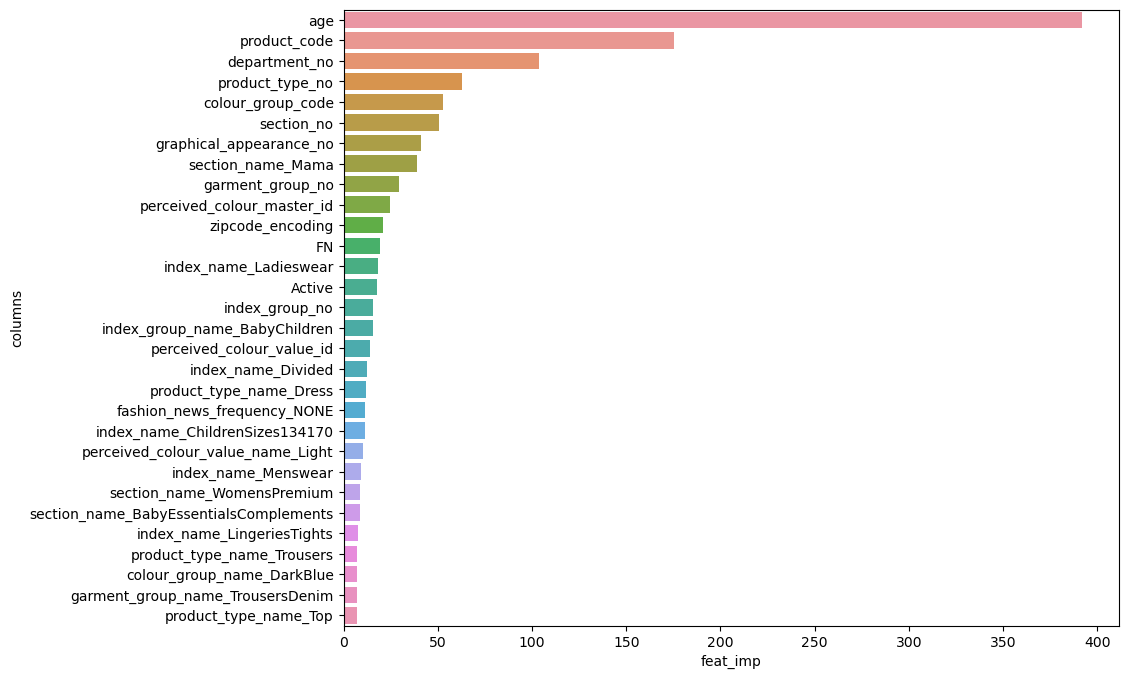

In [43]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_fea_imp.head(30), x="feat_imp", y="columns")

# Inference (only 10 samples)

In [44]:
df_submission = import_data(Config.sample_submission_path)
df_submission.head()

Memory usage of dataframe is 20.93 MB
Memory usage after optimization is: 49.26 MB
Decreased by -135.3%


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [45]:
len(df_submission.iloc[0, 1].split(" "))

12

In [46]:
df_submission.shape

(1371980, 2)

In [47]:
df_article = import_data(Config.article_path)
df_article = df_article[["article_id"]]

Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%


In [48]:
df_article.head()

,article_id
0,108775015
1,108775044
2,108775051
3,110065001
4,110065002


In [49]:

def inference(df_submission, df_article, df_article_feat, df_customer_feat, models, cols):

    article_candidates = []

    for customer in tqdm.tqdm(df_submission["customer_id"]):
        _df = df_article.copy()
        _df.loc[:, "customer_id"] = customer
        _df = create_dataset_faster(_df, df_article_feat, df_customer_feat)         
        _df = _df[cols]     

        preds = []
        for _fold in range(Config.n_fold):
            pred = models[_fold].predict_proba(_df, num_iteration=models[_fold]._best_iteration)[:, 1]
            preds.append(pred)
        
        pred = np.mean(preds, axis=0)        
        df_pred = pd.DataFrame({"article_id": df_article["article_id"].tolist() , "score": pred})
                
        df_pred = df_pred.sort_values("score", ascending=False).reset_index(drop=True)
        df_pred = df_pred.head(12)
        pred_str = [str(pred) for pred in df_pred["article_id"].tolist()]
        article_candidates.append(" ".join(pred_str))

    df_submission.loc[:, "prediction"] = article_candidates

    return df_submission

**Predict only 10 samples.  
It requires a lot of time to predict all data, 😥**

In [50]:
df_article.shape

(105542, 1)

In [52]:
models = []
for _fold in range(Config.n_fold):
    with open(f"lgbm_fold_{_fold}.joblib", "rb") as f:
        model = joblib.load(f)
        models.append(model)
    
cols = [col for col in df_data.columns if Config.label != col]
df_sub = inference(df_submission.head(10), df_article, df_article_feat, df_customer_feat, models, cols)
# df_sub = inference(df_submission, df_article, df_article_feat, df_customer_feat, models, cols)

100%|██████████| 10/10 [00:18<00:00,  1.84s/it]
/var/folders/g0/20x6481n3qj57ly098mhydk40000gn/T/ipykernel_78707/149149827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission.loc[:, "prediction"] = article_candidates
/var/folders/g0/20x6481n3qj57ly098mhydk40000gn/T/ipykernel_78707/149149827.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_submission.loc[:, "prediction"] = article_candidates


In [53]:
df_sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,738330003 541308030 541308026 541308022 541308...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,919248002 894140003 869691002 894140004 854279...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,861471001 869691001 866508001 868018001 865595...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,779957003 774105001 773720001 811943001 810832...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,713712001 646149001 558980002 558980004 648385...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,829343001 907027001 699318002 717577002 707449...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,685814003 738713021 738713002 738713038 730570...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,597901005 708485002 751794001 737098002 697256...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,738713029 738713024 685814003 717995010 685814...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,738713029 738713024 685814003 717995010 685814...


In [ ]:
df_sub.to_csv("submit.csv", index=None)